In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from multiprocessing.pool import ThreadPool as Pool

In [2]:
import random
from tqdm import tqdm
tqdm.pandas()

In [3]:
import multiprocess as mp
from scipy.interpolate import make_interp_spline, BSpline


# Points Tracker

Tracking league's Total Points, Home Points, Away Points, xPoints

Possible next post: scout forward game by game shots xG. Get highest and lowest xG per game. Get correlation of performance and xG.

In [4]:
league = "Brasileirao".replace(" ", "_")

In [5]:
games = pd.read_csv(f"game_db/{league}_games.csv")

how = "all"

hpn_games = games[~games.Score.isna()].copy()
xp = pd.read_csv(f"xp_calc/{league}_xp.csv")
xp.drop("Unnamed: 0", axis=1, inplace=True)
hpn_games = hpn_games.merge(xp, how="left", on="ids")

lw = int(max(hpn_games.Wk.drop_duplicates()))
if how != "all":
    delim = int(how[1])
    hpn_games = hpn_games[hpn_games["Wk"]> (lw-delim)]
    

In [6]:
teams = games.drop_duplicates("Home").Home.values

In [7]:
shots = pd.read_csv(f"game_db/{league}_games_det.csv")

In [8]:
hpn_games

,Wk,Day,Date,Time,Home,Home_xG,Score,Away_xG,Away,Attendance,...,Referee,Match Report,Notes,game_link,ids,Season,Home_Score,Away_Score,Home_xP,Away_xP
0,1.0,Sat,2023-04-15,16:00,América (MG),1.1,0–3,3.1,Fluminense,6653.0,...,Braulio da Silva Machado,Match Report,NaN,/en/matches/3f9c38cd/America-MG-Fluminense-Apr...,3f9c38cd,2023,0.0,3.0,0.20,2.72
1,1.0,Sat,2023-04-15,16:00,Palmeiras,3.0,2–1,1.0,Cuiabá,35835.0,...,Paulo Cesar Zanovelli da Silva,Match Report,NaN,/en/matches/b959f7a3/Palmeiras-Cuiaba-April-15...,b959f7a3,2023,2.0,1.0,2.69,0.20
2,1.0,Sat,2023-04-15,18:30,Bragantino,2.0,2–1,0.7,Bahia,3368.0,...,Maguielson Lima Barbosa,Match Report,NaN,/en/matches/94647e41/Bragantino-Bahia-April-15...,94647e41,2023,2.0,1.0,2.66,0.22
3,1.0,Sat,2023-04-15,18:30,Botafogo (RJ),0.9,2–1,2.0,São Paulo,11708.0,...,Ramon Abatti Abel,Match Report,NaN,/en/matches/d5b8d3df/Botafogo-RJ-Sao-Paulo-Apr...,d5b8d3df,2023,2.0,1.0,0.49,2.32
4,1.0,Sat,2023-04-15,18:30,Ath Paranaense,0.8,2–0,1.0,Goiás,15329.0,...,Rafael Rodrigo Klein,Match Report,NaN,/en/matches/d6629544/Athletico-Paranaense-Goia...,d6629544,2023,2.0,0.0,1.06,1.64
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
292,30.0,Sun,2023-10-29,16:00,Goiás,1.1,1–1,0.9,Vasco da Gama,12904.0,...,Flavio de Souza,Match Report,NaN,/en/matches/725eed20/Goias-Vasco-da-Gama-Octob...,725eed20,2023,1.0,1.0,NaN,NaN
293,30.0,Sun,2023-10-29,18:30,Corinthians,1.2,1–1,1.3,Santos,NaN,...,Anderson Daronco,Match Report,NaN,/en/matches/4ad2d187/Corinthians-Santos-Octobe...,4ad2d187,2023,1.0,1.0,NaN,NaN
294,30.0,Sun,2023-10-29,18:30,Internacional,2.6,3–4,2.7,Coritiba,NaN,...,André Luiz Skettino Policarpo Bento,Match Report,NaN,/en/matches/644ef519/Internacional-Coritiba-Oc...,644ef519,2023,3.0,4.0,NaN,NaN
295,30.0,Sun,2023-10-29,20:00,Botafogo (RJ),1.9,0–1,1.0,Cuiabá,30659.0,...,Wilton Pereira Sampaio,Match Report,NaN,/en/matches/263b2f87/Botafogo-RJ-Cuiaba-Octobe...,263b2f87,2023,0.0,1.0,NaN,NaN


In [9]:

# Total Points, Home Points, Away Points, xPoints
home_points = []
away_points = []

home_xpoints = []
away_xpoints = []

In [10]:
for i, g in hpn_games.iterrows():
    hg = g["Home_Score"]
    ag = g["Away_Score"]
    ht = g["Home"]
    at = g["Away"]
    hxg = round(g["Home_xG"])
    axg = round(g["Away_xG"])
    
    if hg > ag:
        home_points.append(3)
        away_points.append(0)
    elif hg < ag:
        home_points.append(0)
        away_points.append(3)
    else:
        home_points.append(1)
        away_points.append(1)
    

In [11]:
hpn_games["Home_Points"] = home_points
hpn_games["Away_Points"] = away_points

#hpn_games["Home_xPoints"] = home_xpoints
#hpn_games["Away_xPoints"] = away_xpoints

In [12]:
base = hpn_games.groupby("Home")["Home_Points"].sum().to_frame()
base["Away_Points"] = hpn_games.groupby("Away")["Away_Points"].sum()
if how == "all":
    from downloader import *

    page = get_page("https://fbref.com/en/comps/24/")
    team_points = pd.read_html(page.content)[0]
    base = team_points[["Squad","Pts"]].merge(base, how="left", left_on="Squad", right_index=True).set_index("Squad").rename({"Pts":"Total_Points"}, axis=1)

else:
    base["Total_Points"] = base["Away_Points"]+base["Home_Points"]
    base = base.reset_index().rename({"Home": "Team"}, axis=1).set_index("Team")

In [13]:
hpn_games.Home_Points

0      0
1      3
2      3
3      3
4      3
      ..
292    1
293    1
294    0
295    0
296    3
Name: Home_Points, Length: 297, dtype: int64

In [14]:
base

,Total_Points,Home_Points,Away_Points
Squad,,,
Botafogo (RJ),59,35,24
Palmeiras,53,32,21
Bragantino,52,31,21
Grêmio,50,35,15
Flamengo,50,25,25
Atlético Mineiro,49,24,25
Ath Paranaense,49,33,16
Fluminense,45,37,8
Fortaleza,42,28,14


$$ xP = \frac{(TeamWins*3) + (TeamDraws*1)}{Number\ of\ Simulations} $$

In [15]:
def sim_game(v):
    #mid is the match ID
    #ht is home team and at is away team
    mid, ht, at = v[0], v[1], v[2]
    
    #selecting home team shots in the game
    home_sht = shots[(shots.match_id == mid) & (shots.Squad == ht)]
    
    #selecting away team shots in the game
    away_sht = shots[(shots.match_id == mid) & (shots.Squad == at)]
    
    #simulating HT goals
    home_goals = 0
    for i, s in home_sht.iterrows():
        
        x = random.random()
        if s["xG"] > x:
            home_goals+=1
    
    #simulating AT goals
    away_goals = 0
    for i, s in away_sht.iterrows():
        x = random.random()
        if s["xG"] > x:
            away_goals+=1
    
    #seeing match winner
    if home_goals > away_goals:
        return "home"
    elif away_goals > home_goals:
        return "away"
    else:
        return "draw"

In [16]:
def get_xp(mid, ht, at, n=500):
    home_wins = 0
    away_wins = 0
    draws = 0
    
    sim_vals = (mid, ht, at)
    
    res = []
    for i in range(n):
        res.append(sim_game(sim_vals))
        
    
    home_wins = len([a for a in res if a=="home"])
    away_wins = len([a for a in res if a=="away"])
    draws = len([a for a in res if a=="draw"])
    
    home_points = ((home_wins*3)+(draws))/n
    away_points = ((away_wins*3)+(draws))/n
    return home_points, away_points

In [17]:
#get_xp("42c7113e", "Palmeiras", "Goiás")

In [18]:
get_xp(hpn_games["ids"].values[0], hpn_games["Home"].values[0], hpn_games["Away"].values[0])

(0.256, 2.656)

In [19]:
#hpn_games.values[0][9]

In [20]:
if len(hpn_games[hpn_games.Home_xP.isna()]) > 0:
    hxp, axp =  zip(*hpn_games.loc[hpn_games["Home_xP"].isna(), :].progress_apply(lambda x: get_xp(x["ids"], x["Home"], x["Away"]), axis=1))

100%|██████████████████████████████████████████████████████████████████████████████████| 47/47 [03:29<00:00,  4.45s/it]


In [21]:
if len(hpn_games[hpn_games.Home_xP.isna()])>0:
    hpn_games.loc[hpn_games["Home_xP"].isna(), "Home_xP"] = hxp
    hpn_games.loc[hpn_games["Away_xP"].isna(), "Away_xP"] = axp

In [23]:
hpn_games[["ids", "Home_xP", "Away_xP"]].to_csv(f"xp_calc/{league}_xp.csv")

In [24]:
hpn_games["Home_xP"], hpn_games["Away_xP"] = hpn_games.Home_xP.round(2), hpn_games.Away_xP.round(2)

In [25]:
xp = hpn_games.groupby("Home")["Home_xP"].sum().to_frame()
xp["Away_xP"] = hpn_games.groupby("Away")["Away_xP"].sum()
xp["Total_xP"] = xp["Away_xP"]+xp["Home_xP"]

In [26]:
full_b = base.merge(xp["Total_xP"], how="left", left_index=True, right_index=True)#.sort_values("Total_xP")

In [27]:
full_b = full_b.reset_index().rename({"Squad": "Team"}, axis=1)[["Team", "Total_Points", "Home_Points", "Away_Points", "Total_xP"]]

In [30]:
full_b.sort_values("Total_xP")

,Team,Total_Points,Home_Points,Away_Points,Total_xP
18,Coritiba,23,12,11,30.45
11,Internacional,38,24,14,35.36
16,Goiás,32,19,13,35.91
19,América (MG),19,13,6,36.61
15,Santos,34,23,11,37.02
13,Corinthians,37,24,13,37.33
14,Bahia,34,22,12,37.81
3,Grêmio,50,35,15,37.98
9,Cuiabá,40,18,22,38.12
12,Cruzeiro,37,17,20,40.46


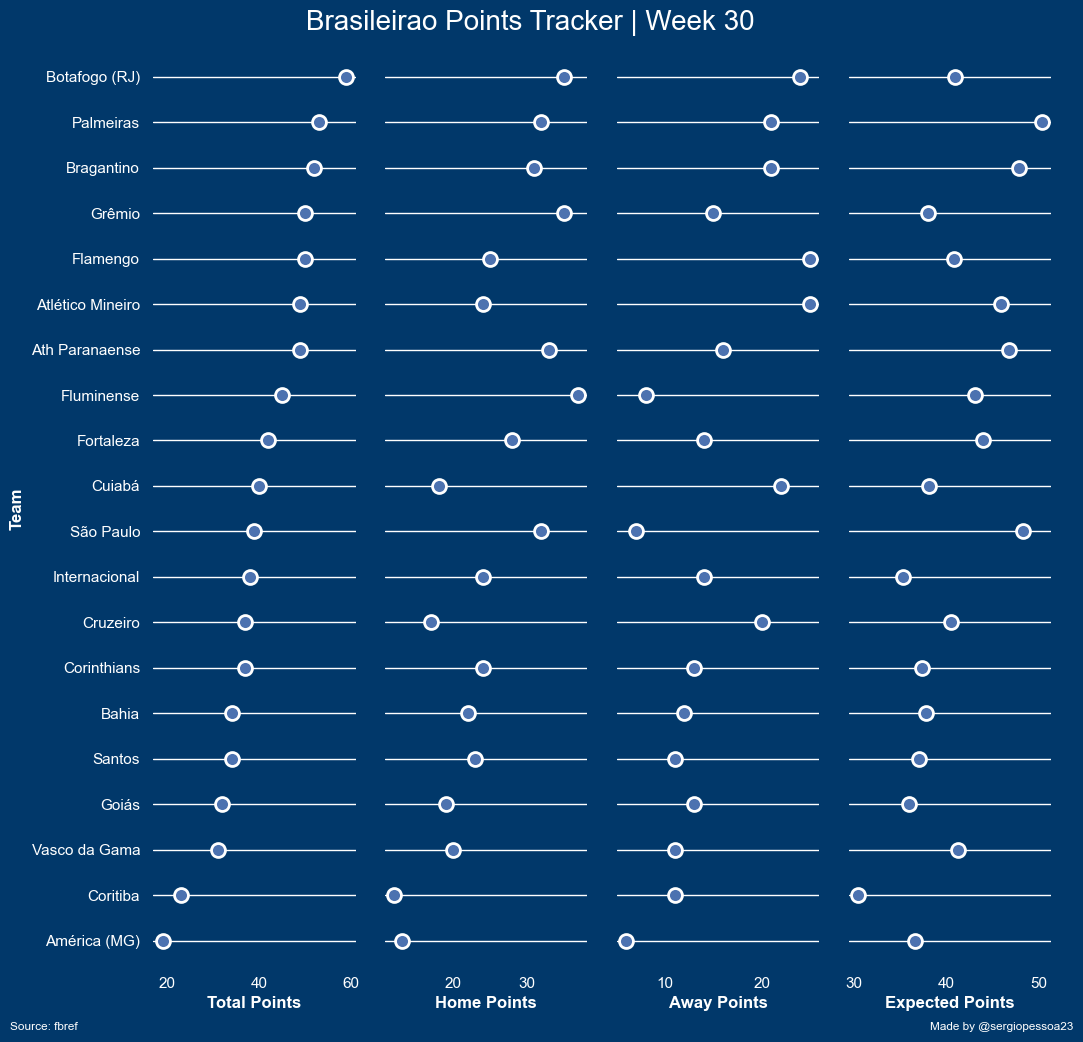

In [31]:
sns.set_theme(style="white")
sns.set(rc={'axes.facecolor':'#01386a', 'figure.facecolor':'#01386a'})
#sns.set(c)

g = sns.PairGrid(full_b, x_vars=full_b.columns[1:], y_vars=["Team"], height=10, aspect=.25)

g.map(sns.stripplot, size=10, orient="h", jitter=False, palette="deep", linewidth=2, edgecolor="w")

g.set(xlabel = "")

if how == "all":
    title =  f"{league} Points Tracker | Week {lw}\n"

else:
    title =  f"{league} Points Tracker | Last {delim} Weeks\n"
    
g.fig.suptitle(title, fontsize=20, x= .45, y=1.02, fontname="Arial", color="white")
g.fig.text( -0.07, 0,"Source: fbref", color="white", fontsize=8.5)
g.fig.text( 0.85, 0,"Made by @sergiopessoa23", color="white", fontsize=8.5)

titles = ["Total Points", "Home Points", "Away Points", "Expected Points"]
for ax, title in zip(g.axes.flat, titles):

    # Set a different title for each axes
    #ax.set(xlabel=title)
    ax.tick_params( colors='white')
    ax.set_xlabel(title, color ="white", fontweight="bold")
    ax.set_ylabel("Team", color="white", fontweight="bold")
    #ax.set_yticklabels(ax.get_yticks(), weight='bold')
    #ax.set_xticklabels(ax.get_xticks(), weight='bold')


    # Make the grid horizontal instead of vertical
    
    ax.xaxis.grid(False)
    ax.yaxis.grid(True)

sns.despine(left=True, bottom=True)

In [32]:
ou = (full_b["Total_Points"] - full_b["Total_xP"])
ou_table = full_b.copy()
ou_table["O_U"] = ou

Text(0, 0.5, 'Team')

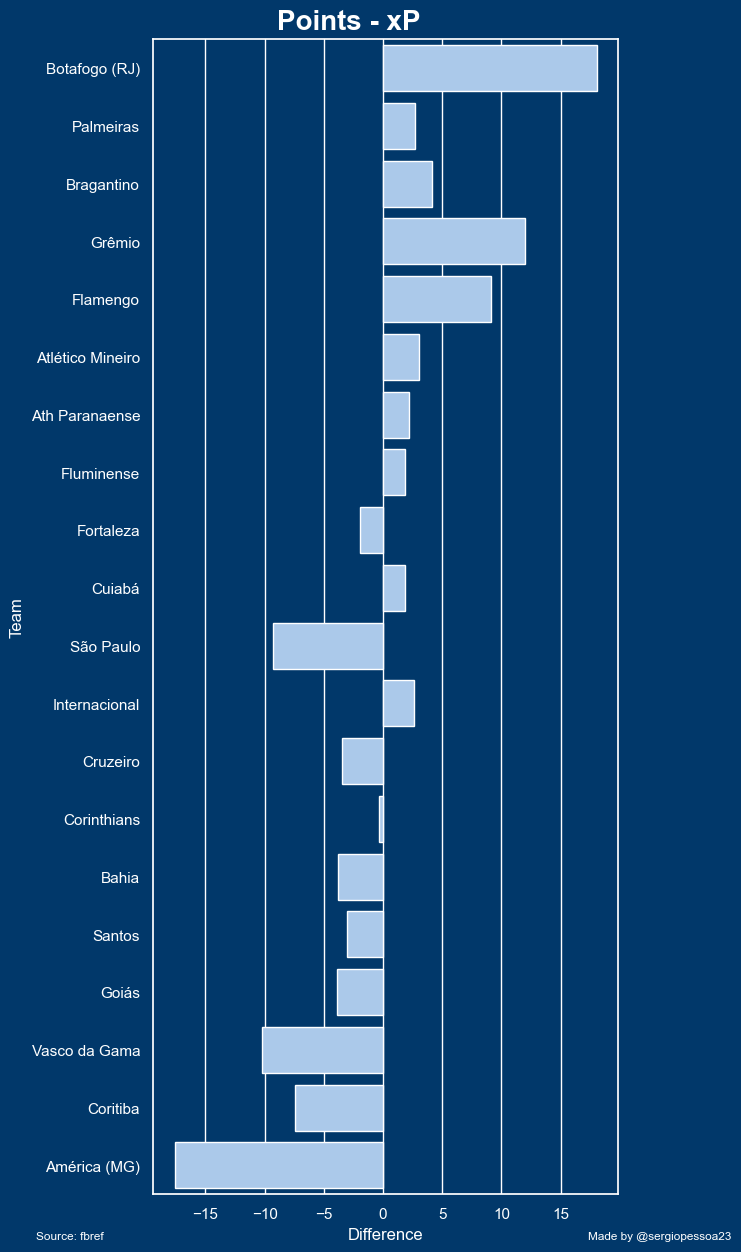

In [33]:
#sns.set_theme(style="whitegrid")

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(6, 15))

sns.set_color_codes("pastel")
sns.barplot(y="Team", x="O_U", data=ou_table,label="Total", color="b")

f.suptitle("Points - xP", fontsize=20, x= .45, y=.90, fontname="Arial", color="white", fontweight="bold")
f.text( -0.07, 0.08,"Source: fbref", color="white", fontsize=8.5)
f.text( 0.85, 0.08,"Made by @sergiopessoa23", color="white", fontsize=8.5)
ax.tick_params(colors='white')
ax.set_xlabel("Difference", c="white")
ax.set_ylabel("Team", c="white")

In [35]:
last_week = hpn_games[hpn_games.Wk == 30]

In [36]:
last_week["match_winner"] = last_week.apply(lambda x: x["Home"] if x["Home_Points"] == 3 else x["Away"] if x["Away_Points"] == 3 else "Draw", axis=1)

C:\Users\sergi\AppData\Local\Temp\ipykernel_17724\3168190851.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_week["match_winner"] = last_week.apply(lambda x: x["Home"] if x["Home_Points"] == 3 else x["Away"] if x["Away_Points"] == 3 else "Draw", axis=1)


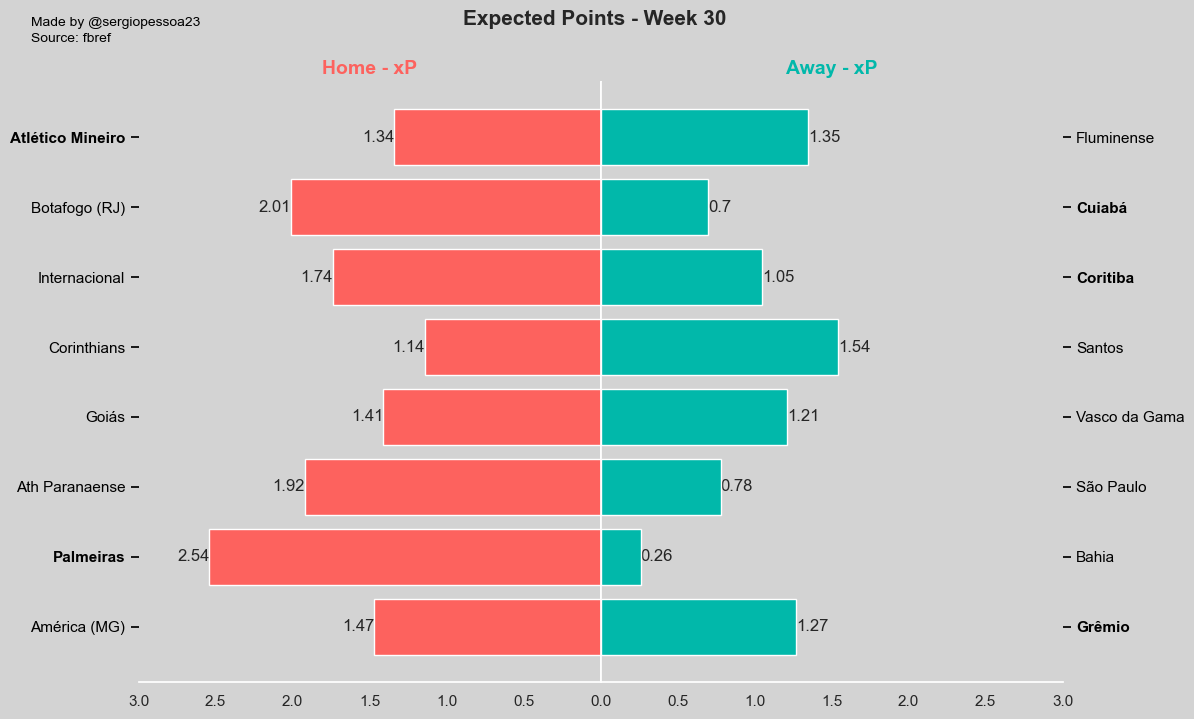

In [37]:
sns.set(rc={'axes.facecolor':'lightgrey', 'figure.facecolor':'lightgrey'})


fig, axes = plt.subplots(figsize=(12,8), facecolor= "lightgrey", ncols=2)
fig.tight_layout()
fig.suptitle(f"Expected Points - Week {int(last_week.Wk.values[0])}", fontsize=15, x= .56, y=0.94, fontweight="bold")


bar0 = axes[0].barh(last_week["Home"], last_week["Home_xP"], align='center', color="#fd625e", zorder=10)
axes[0].set_title("Home - xP", color = "#fd625e", fontsize=14, fontweight="bold")
#axes[0].set_title(title0, fontsize=18, pad=15, color=color_red, **hfont)
bar1 = axes[1].barh(last_week["Away"], last_week["Away_xP"], align='center', color="#01b8aa", zorder=10)
axes[1].set_title("Away - xP", color = "#01b8aa", fontsize=14, fontweight="bold")

fig.text( 0.09, 0.9,"Source: fbref", color="black", fontsize=10)
fig.text( 0.09, 0.92,"Made by @sergiopessoa23", color="black", fontsize=10)
#fig.suptitle("Winners in bold", color="black", fontsize=10)
#g.fig.text( 0.85, 0,"Made by @sergiopessoa23", color="white", fontsize=8.5)

#axes[1].set_title(title1, fontsize=18, pad=15, color=color_blue, **hfont)
axes[0].invert_xaxis() 

axes[0].set(yticks=last_week["Home"], yticklabels=last_week["Home"])
axes[0].yaxis.tick_left()
axes[0].tick_params(axis='y', colors='black')

axes[0].set_xticks([0.5, 1, 1.5, 2, 2.5, 3])

axes[1].set_xticks([0, 0.5, 1, 1.5, 2, 2.5, 3])

axes[1].set(yticks=last_week["Away"], yticklabels=last_week["Away"])
axes[1].yaxis.tick_right()
axes[1].tick_params(axis='y', colors='black')

axes[0].bar_label(bar0)
axes[1].bar_label(bar1)

#axes[1].set_yticks(last_week["Away"].values.tolist())
axes[0].grid(False)
axes[1].grid(False)

for label in (axes[0].get_xticklabels() + axes[0].get_yticklabels()):
    tx = label.get_text()
    if isinstance(tx, float):
        label.set(fontweight="bold")
    elif tx in last_week.match_winner.values:
        label.set(fontweight="bold")
for label in (axes[1].get_xticklabels() + axes[1].get_yticklabels()):
    tx = label.get_text()
    if isinstance(tx, float):
        label.set(fontweight="bold")
    elif tx in last_week.match_winner.values:
        label.set(fontweight="bold")
    
plt.subplots_adjust(wspace=0, top=0.85, bottom=0.1, left=0.18, right=0.95)
#axes[0].spines['top'].set_visible(False)
axes[0].spines['top'].set_visible(False)
axes[0].spines['left'].set_visible(False)

axes[1].spines['top'].set_visible(False)
axes[1].spines['right'].set_visible(False)
#axes[0].yaxis.set_tick_params(labelleft=False)


In [38]:
def find_team_xP(tm, hxp, axp, ht, at):
    if tm == ht:
        return hxp
    elif tm == at:
        return axp

In [39]:
#tg#[hpn_games.Home == "Botafogo (RJ)"]

In [77]:
team = "Flamengo"#"Palmeiras"#
color = "navy"

tg = hpn_games[(hpn_games["Home"] == (team)) | (hpn_games["Away"] == (team))].copy()
tg["team_xP"] = tg.apply(lambda x: find_team_xP(team, x["Home_xP"], x["Away_xP"], x["Home"], x["Away"]), axis=1)
tg["team_P"] = tg.apply(lambda x: find_team_xP(team, x["Home_Points"], x["Away_Points"], x["Home"], x["Away"]), axis=1)

tg["xP_ma"] = tg.team_xP.rolling(window=5).mean()
tg["P_ma"] = tg.team_P.rolling(window=5).mean()
tg_back = tg.copy()
tg = tg[~tg.xP_ma.isna()]




#interpolate to get a smoother curve
#tg["Wk"] = tg.
xnew = np.linspace(tg.Wk.min(), tg.Wk.max(), 300)
spl = make_interp_spline(tg.Wk, tg.xP_ma, k=3)

ma_smt = spl(xnew)

xnew = np.linspace(tg.Wk.min(), tg.Wk.max(), 300)
spl = make_interp_spline(tg.Wk, tg.P_ma, k=3)

p_smt = spl(xnew)

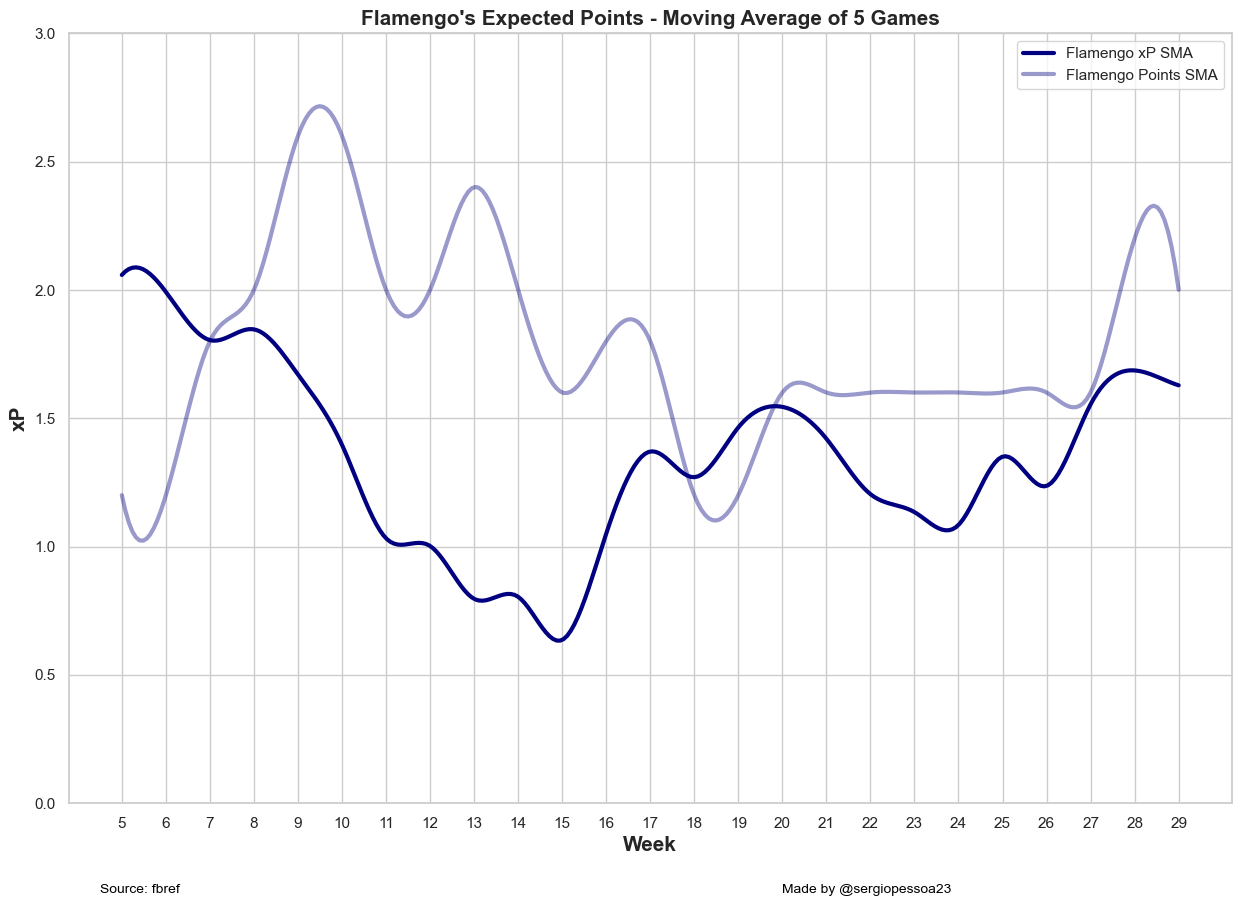

In [78]:
sns.set_theme(style="whitegrid")
plt.figure(figsize=(15, 10))

plt.plot(xnew, ma_smt, color=color, linewidth=3, alpha = 1, label=f"{team} xP SMA")
plt.plot(xnew, p_smt, color=color, linewidth=3, alpha=0.4, label=f"{team} Points SMA")
plt.yticks([0, 0.5, 1, 1.5, 2, 2.5, 3])
plt.xticks(np.arange(5, tg.Wk.max()+1))

plt.xlabel("Week", fontweight="bold", fontsize=15)
plt.ylabel("xP", fontweight="bold", fontsize=15)

#trans = plt.get_xaxis_transform()

#TRACK EVENTS - CHANGE TEAM BY TEAM
xcoords = [16, 11]
xlabels = []
for xc, xl in zip(xcoords, xlabels):
    plt.axvline(x=xc, ls="--", color=color)
    
    plt.text(xc+0.05, 2.6, xl)


plt.title(f"{team}'s Expected Points - Moving Average of 5 Games", fontweight="bold", fontsize=15)

plt.text( 4.5, -.35,"Source: fbref", color="black", fontsize=10)
plt.text( 20,-.35,"Made by @sergiopessoa23", color="black", fontsize=10)

plt.legend()
plt.show()

In [79]:
tg_back[["Home","Away","team_xP","team_P", "xP_ma", "P_ma"]]#.mean()

,Home,Away,team_xP,team_P,xP_ma,P_ma
6,Flamengo,Coritiba,2.30,3,NaN,NaN
13,Internacional,Flamengo,1.68,0,NaN,NaN
25,Flamengo,Botafogo (RJ),1.85,0,NaN,NaN
32,Ath Paranaense,Flamengo,1.80,0,NaN,NaN
44,Flamengo,Goiás,2.66,3,2.058,1.2
50,Bahia,Flamengo,1.97,3,1.992,1.2
66,Flamengo,Corinthians,0.74,3,1.804,1.8
73,Flamengo,Cruzeiro,2.06,1,1.846,2.0
89,Vasco da Gama,Flamengo,0.92,3,1.670,2.6
97,Flamengo,Grêmio,1.29,3,1.396,2.6


In [43]:
59+((38-29)*1.422)

71.798

In [76]:
52+(38-29)*1.73

67.57

In [80]:
50+(38-29)*1.628

64.652